# Ramp4 -- PCA and Mahalanobis distance

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile #Process ramping file


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## 0. Helper functions 

In [2]:
def read_data_from_single_file(filepath):
    """Read in quench data from a given file, return a pandas dafa frame"""
    
    data_dict= {}
    
    with open(filepath) as f:
        content = f.readlines()
    #Remove`\n` at the end of each line
    content = [x.strip() for x in content]
    
    column_names = content[0].split(" ")
    data = [content[i].split("   ") for i in range(1, len(content))] 
    
    for i in range(len(column_names)):
        data_dict[column_names[i]] = [float(x[i]) for x in data]
        
    data_frame = pd.DataFrame(data_dict)
    
    return data_frame

def read_quench_data(area_path, quench_name):
    """
    Read the quench data from the provided file path, note that there are five quenches so we need to concatenate them together.
    Just need to provide the quench's name, for e.g: "./data/mqxfs1b.Quench.161011115654"
    """
    
    data_list = []
    
    
    num_file = 0 #Number of separate data files for this quench, assuming at least one
    
    for filename in os.listdir(area_path):
        if filename.startswith(quench_name) and not filename.endswith(".tar.gz"):
            #print("Reading file ... " + filename)
            if num_file == 0:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename)) #read first file separately
                except:
                    pass
            else:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename).drop(columns = ["time"])) #Time is already saved in the first file
                except:
                    pass
            num_file += 1
                                 
    #print("Total number of data files for {}: ".format(quench_name), num_file)
    
    if len(data_list) != 0:
        data = pd.concat(data_list, axis = 1) #Concatenate all data files together
        return data
    else:
        print("Returning None due to file errors in " + quench_name)
        return None

def read_all_quench_in_area(area_path):
    """
    Read all quench's files in the area and return a dictionary of different quench's data. name is the magnet's name
    """
    data = {}
    
    index = 1 #For indexing different quench

    for filename in os.listdir(area_path):
        if filename.endswith(".tar.gz"): 
            #print("Reading data from ... " + filename[0:-7])
            data[filename[0:-7]] = read_quench_data(area_path, filename[0:-7])
            index += 1
            
    #print("Completed. There are {} quenches in total.".format(str(index - 1)))
    
    return data

def plot_variables_with_time(data, variables = None, time_range = None):
    """
    Take a data frame, and plot all other variables with time.
    Optional argument: time_range to specify the range to plot, default is to plot all time. Example argument
    is (start_time, end_time)
    """
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    if variables:
        for variable in variables:
            plt.figure(figsize=(20,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()
        
    else:      
        #If variables not specified then just plot all 
        for variable in data.columns[1:]:
            plt.figure(figsize=(25,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()

def plot_statistics(data, variables = None, time_range = None, window = 100):
    """Take a data frame and plot the variable with its moving average and real data in the specified range, if
    variables are not specified then just plot all variables by default"""
    #Pickout the data
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    def plot_signal_and_statistics(variable):
        # Plotted by calculating Simple Moving Average (SMA)
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data[variable], label = "Signal with noise")
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).mean(),label = "Moving average")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).min(),label = "Moving min")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).max(),label = "Moving max")
        plt.legend(loc = "best")
        plt.xlabel("Time (s)")
        plt.title("Variable {}".format(variable))
        plt.show()
        
        
        #Variance
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).std(),
                 label = "Variance",
                 color = 'red')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Variance".format(variable))
        plt.show()
        
        #Kurtosis
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).kurt(),
                 label = "Kurtosis",
                 color = 'green')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Kurtosis".format(variable))
        plt.show()
        
        #Skew
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).skew(),
                 label = "Skew",
                 color = 'purple')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Skew".format(variable))
        plt.show()
        
        """
        #Quantile
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.25), label = "Quantile 25",
                 color = 'red')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.75), label = "Quantile 75",
                 color = 'orange')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.50), label = "Quantile 50",
                 color = 'green')
        plt.legend(loc = "best")
        plt.title("Variable {}'s Quantile".format(variable))
        plt.show()
        """
        
    #Plot
    if variables:
        for variable in variables:
            print(variable)
            plot_signal_and_statistics(variable)         
    else:
        for variable in data.columns[1:]:
            print(variable)
            plot_signal_and_statistics(variable)
    
    %reset -f in

def plot_variable(data_dict, variable, time_range = None, window = 100):
    for quench_name in data_dict.keys():
        print("Quench's index: " + quench_name)
        if data_dict[quench_name] is not None:
            if variable[0] in list(data_dict[quench_name].columns):
                plot_statistics(data_dict[quench_name], variables = variable, time_range=time_range, window=window)

In [3]:
def read_data_from_single_file(filepath):
    """Read in quench data from a given file, return a pandas dafa frame"""
    
    data_dict= {}
    
    with open(filepath) as f:
        content = f.readlines()
    #Remove`\n` at the end of each line
    content = [x.strip() for x in content]
    
    column_names = content[0].split(" ")
    data = [content[i].split("   ") for i in range(1, len(content))] 
    
    for i in range(len(column_names)):
        data_dict[column_names[i]] = [float(x[i]) for x in data]
        
    data_frame = pd.DataFrame(data_dict)
    
    return data_frame

def read_quench_data(area_path, quench_name):
    """
    Read the quench data from the provided file path, note that there are five quenches so we need to concatenate them together.
    Just need to provide the quench's name, for e.g: "./data/mqxfs1b.Quench.161011115654"
    """
    
    data_list = []
    
    
    num_file = 0 #Number of separate data files for this quench, assuming at least one
    
    for filename in os.listdir(area_path):
        if filename.startswith(quench_name) and not filename.endswith(".tar.gz"):
            #print("Reading file ... " + filename)
            if num_file == 0:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename)) #read first file separately
                except:
                    pass
            else:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename).drop(columns = ["time"])) #Time is already saved in the first file
                except:
                    pass
            num_file += 1
                                 
    #print("Total number of data files for {}: ".format(quench_name), num_file)
    
    if len(data_list) != 0:
        data = pd.concat(data_list, axis = 1) #Concatenate all data files together
        return data
    else:
        print("Returning None due to file errors in " + quench_name)
        return None

def read_all_quench_in_area(area_path):
    """
    Read all quench's files in the area and return a dictionary of different quench's data. name is the magnet's name
    """
    data = {}
    
    index = 1 #For indexing different quench

    for filename in os.listdir(area_path):
        if filename.endswith(".tar.gz"): 
            #print("Reading data from ... " + filename[0:-7])
            data[filename[0:-7]] = read_quench_data(area_path, filename[0:-7])
            index += 1
            
    #print("Completed. There are {} quenches in total.".format(str(index - 1)))
    
    return data

def plot_variables_with_time(data, variables = None, time_range = None):
    """
    Take a data frame, and plot all other variables with time.
    Optional argument: time_range to specify the range to plot, default is to plot all time. Example argument
    is (start_time, end_time)
    """
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    if variables:
        for variable in variables:
            plt.figure(figsize=(20,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()
        
    else:      
        #If variables not specified then just plot all 
        for variable in data.columns[1:]:
            plt.figure(figsize=(25,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()

def plot_statistics(data, variables = None, time_range = None, window = 100):
    """Take a data frame and plot the variable with its moving average and real data in the specified range, if
    variables are not specified then just plot all variables by default"""
    #Pickout the data
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    def plot_signal_and_statistics(variable):
        # Plotted by calculating Simple Moving Average (SMA)
        plt.figure(figsize=(20,2))
        
        plt.plot(data["time"], data[variable], label = "Signal with noise")
        
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).mean(),label = "Moving average")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).min(),label = "Moving min")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).max(),label = "Moving max")
        plt.legend(loc = "best")
        plt.xlabel("Time (s)")
        plt.title("Variable {}".format(variable))
        plt.show()
        

        #Variance
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).std(),
                 label = "Standard Deviation",
                 color = 'red')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Standard Deviation".format(variable))
        plt.show()
        
        #Kurtosis
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).kurt(),
                 label = "Kurtosis",
                 color = 'green')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Kurtosis".format(variable))
        plt.show()
        
        #Skew
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).skew(),
                 label = "Skew",
                 color = 'purple')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Skew".format(variable))
        plt.show()
        
        """
        #Quantile
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.25), label = "Quantile 25",
                 color = 'red')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.75), label = "Quantile 75",
                 color = 'orange')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.50), label = "Quantile 50",
                 color = 'green')
        plt.legend(loc = "best")
        plt.title("Variable {}'s Quantile".format(variable))
        plt.show()
        """
        
    #Plot
    if variables:
        for variable in variables:
            print(variable)
            plot_signal_and_statistics(variable)         
    else:
        for variable in data.columns[1:]:
            print(variable)
            plot_signal_and_statistics(variable)
    
    %reset -f in

def plot_variable(data_dict, variable, time_range = None, window = 100):
    for quench_name in data_dict.keys():
        print("Quench's index: " + quench_name)
        if data_dict[quench_name] is not None:
            if variable[0] in list(data_dict[quench_name].columns):
                plot_statistics(data_dict[quench_name], variables = variable, time_range=time_range, window=window)


########### PROCESS RAMPING DATA ###############
def read_tdms_file(filepath):
    """Read the tdms file from a given path, return a pandas data frame of the tdms file"""
    tdms_file = TdmsFile.read(data_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    #Just the last 3 symbols in columns name matter ('/'_unnamedTask<3>'/'PXI2Slot14/ai0') -> ai0
    #Rename the columns
    rename_map = []
    
    for column in data_frame.columns:
        rename_map.append(column[-4:-1])
    
    data_frame.columns = rename_map
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(data_frame.shape[0]))
    

    #Center around the max value (quench happens at 0 time)
    max_index = data_frame['ai7'].idxmax()
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    data_frame['time'] = time_range
    
    return data_frame

def break_tdms_to_files(file_path):
    """Read the tdms file and break it into several files according to channels in a new directory"""
    tdms_file = TdmsFile.read(file_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    os.mkdir("./data/" + file_path[-10:-5])
    
    for channel in data_frame.columns:
        np.save("./data/{}/{}".format(file_path[-10:-5], channel[-4:-1]), data_frame.loc[:, channel].to_numpy())

def calculate_time(dir_path):
    """Take a tdms file directory path (after the file is broken up), and calculate and output a time file."""
    
    ai7 = np.load(dir_path + "ai7.npy")
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(ai7.shape[0]))
    
    #Center around the max value (quench happens at 0 time)
    max_index = np.argmax(ai7)
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    np.save(dir_path + "time", time_range)

def load_channel_and_time(dir_path, channel):
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    return data_frame

def plot_channel(data, channel, time_range = None):
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data[channel])
    plt.title("Variable {}".format(channel))
    plt.show()
    
    %reset -f in

def load_and_plot(dir_path, channel, time_range = None, stat = False, window = 100):
    ai = load_channel_and_time(dir_path, channel)
    
    if stat:
        plot_statistics(ai, variables = [channel], time_range = time_range, window = window)
    else:
        plot_channel(ai, channel, time_range = time_range)
    
    %reset -f in

In [4]:
def generate_data(dir_path, channel, time_range, window = 100):
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the statistics
    #data["Mean"] = data.loc[:, channel].rolling(window=window).mean()
    data["SD"] = data.loc[:, channel].rolling(window=window).std()
    data["Kurtosis"] = data.loc[:, channel].rolling(window=window).kurt()
    data["Skew"] = data.loc[:, channel].rolling(window=window).skew()
    
    select_list = [channel, "SD", "Kurtosis", "Skew"]
    
    %reset -f in
    
    return data[select_list].to_numpy()[window-1:], data['time'].to_numpy()[window-1:]

## 1. Ramp 4 -- ai2 -- PCA & Mahalanobis distance for single channel

In [5]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

### 1.1 Visualize training and test data

In [6]:
#load_and_plot("./data/Ramp4/", "ai2", time_range = (-50, 0), stat=True, window = 200000)

### 1.2 Generate training and testing data

In [6]:
X_train, train_time = generate_data("./data/Ramp4/", "ai2", time_range = (-450, -350), window = 200000)
X_test, test_time = generate_data("./data/Ramp4/", "ai2", time_range = (-50, 0), window = 200000)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
X_train's shape:  (9799996, 4)
X_test's shape:  (4800000, 4)


### 1.3 PCA transform

In [7]:
# PCA transform to 2 channels.
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver= 'full')

X_train_PCA = pca.fit_transform(X_train)

X_test_PCA = pca.transform(X_test)

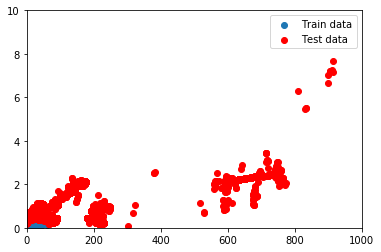

In [16]:
#Visualize the 2D space
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], label = "Train data")
plt.scatter(X_test_PCA[:, 0], X_test_PCA[:,1], c = "red" , label = "Test data")
plt.xlim([0.0,1000])
plt.ylim([0.0,10])
plt.legend(loc = "best")

### 1.4 Calculate Mahalanobis distance for training and test set

In [8]:
cov_matrix, inv_cov_matrix  = cov_matrix(X_train_PCA)

In [9]:
mean_distr = X_train_PCA.mean(axis=0)

In [10]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, X_test_PCA, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, X_train_PCA, verbose=False)
threshold = MD_threshold(X_train_PCA, extreme = True)

### 1.5 Visualize the result

Text(0.5, 0, 'Mahalanobis dist')

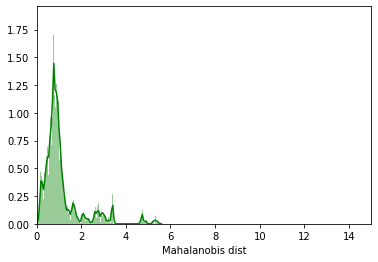

In [46]:
plt.figure()
sns.distplot(dist_train,
             bins = 350, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,15])
plt.xlabel('Mahalanobis dist')

Text(0.5, 0, 'Mahalanobis dist')

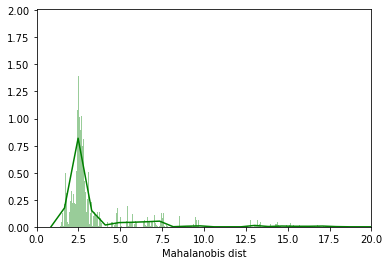

In [51]:
plt.figure()
sns.distplot(dist_test,
             bins = 40000, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,20])
plt.xlabel('Mahalanobis dist')

In [12]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
#anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
#anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
#anomaly_train.index = X_train_PCA.index

anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
#anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
#anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
#anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist
0,3.296092
1,3.296036
2,3.296012
3,3.296019
4,3.296054


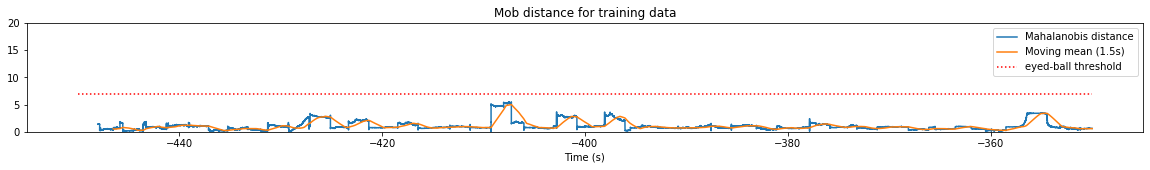

In [13]:
plt.figure(figsize=(20,2))
plt.title("Mob distance for training data")
plt.ylim([0.0,20])
plt.xlabel("Time (s)")
plt.plot(train_time, anomaly_train['Mob dist'], label = "Mahalanobis distance")
plt.plot(train_time, anomaly_train.loc[:, 'Mob dist'].rolling(window=150000).mean(), label = "Moving mean (1.5s)")
plt.hlines(7, xmin = -450, xmax = -350, colors='r', linestyles='dotted', label = "eyed-ball threshold")
plt.legend(loc = "best")

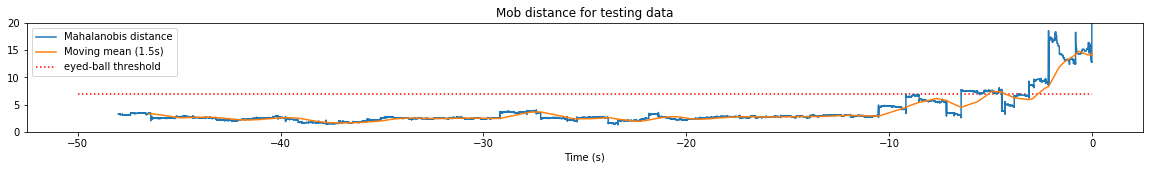

In [14]:
plt.figure(figsize=(20,2))
plt.title("Mob distance for testing data")
plt.ylim([0.0,20])
plt.xlabel("Time (s)")
plt.plot(test_time, anomaly['Mob dist'], label = "Mahalanobis distance")
plt.plot(test_time, anomaly.loc[:, 'Mob dist'].rolling(window=150000).mean(), label = "Moving mean (1.5s)")
plt.hlines(7, xmin = -50, xmax = 0, colors='r', linestyles='dotted', label = "eyed-ball threshold")
plt.legend(loc = "best")

### 1.6 Plot validation data (time before -50s)

In [10]:
X_val, val_time = generate_data("./data/Ramp4/", "ai2", time_range = (-100, -50), window = 200000)

#PCA transform
X_val_PCA = pca.transform(X_val)

#Mahalanobis distance
dist_val = MahalanobisDist(inv_cov_matrix, mean_distr, X_val_PCA, verbose=False)

#Put into a dict
anomaly_val = pd.DataFrame()
anomaly_val['Mob dist']= dist_val

Flushing input history


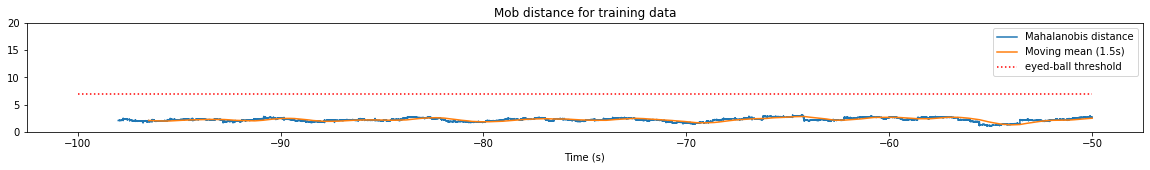

In [12]:
plt.figure(figsize=(20,2))
plt.title("Mob distance for training data")
plt.ylim([0.0,20])
plt.xlabel("Time (s)")
plt.plot(val_time, anomaly_val['Mob dist'], label = "Mahalanobis distance")
plt.plot(val_time, anomaly_val.loc[:, 'Mob dist'].rolling(window=150000).mean(), label = "Moving mean (1.5s)")
plt.hlines(7, xmin = -100, xmax = -50, colors='r', linestyles='dotted', label = "eyed-ball threshold")
plt.legend(loc = "best")

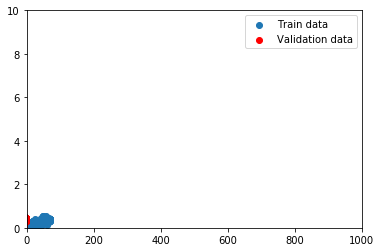

In [17]:
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], label = "Train data")
plt.scatter(X_val_PCA[:, 0], X_val_PCA[:,1], c = "red" , label = "Validation data")
plt.xlim([0.0,1000])
plt.ylim([0.0,10])
plt.legend(loc = "best")